# Deep Learning Foundations Lab with PyTorch : Practice & Experiments

**Authored by Alexandre Mathias DONNAT, Sr - Télécom Paris**

This notebook introduces the core foundations of deep learning using PyTorch, with a focus on tensors, automatic differentiation, data pipelines, and neural network training. It contains:

- Tensor fundamentals and Autograd: creation and manipulation of tensors, memory views and broadcasting, followed by an explicit introduction to PyTorch’s dynamic computational graph and automatic differentiation through simple analytical examples.

- -Linear regression from scratch: manual implementation of gradient descent using Autograd, including forward pass, loss computation, backpropagation, and parameter updates, illustrating the mechanics of optimization without relying on high-level abstractions.

- Custom datasets and data loading: definition of a custom Dataset and DataLoader for noisy sine data, highlighting batching, shuffling, and the separation between data definition and data access in PyTorch.

- Neural network modeling with PyTorch: construction of multilayer perceptrons using both nn.Sequential and nn.Module, emphasizing architectural flexibility, activation functions, and non-linear function approximation.

- Training, evaluation, and generalization: implementation of a full optimization loop with Adam and MSE loss, visualization of convergence and model fit, and empirical studies on model capacity, activation functions, and train/validation splits to analyze learning dynamics and generalization behavior.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt

## Tensors: The Engine of Deep Learning

In PyTorch, a **Tensor** is a multi-dimensional matrix containing elements of a single data type. While they look like NumPy arrays, they have two critical advantages:

1. **Computational Graphs:** They track every operation performed on them to allow for automatic differentiation.
2. **Hardware Acceleration:** They can be loaded onto GPUs/TPUs for massive parallelism.

* **Documentation:** [torch.Tensor](https://pytorch.org/docs/stable/tensors.html)
* **Key Concept:** [Tensor Views vs. Copies](https://pytorch.org/docs/stable/tensor_view.html)

In [3]:
# Task: Initialize a tensor 'x' of shape (5, 3) with random values from a normal distribution. Then, move it to the GPU if available.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = torch.randn(5, 3, device=device)

In [ ]:
# Task: Change the shape of 'x' to (15, 1) without copying memory.
# Hint: Use .view() or .reshape()

x_reshaped = x.view(15, 1)

Deep Learning is essentially high-performance linear algebra. Before training models, we must master **Broadcasting** and **Vectorization**.

* **Documentation:** [Tensor Basics](https://pytorch.org/docs/stable/tensors.html) | [Broadcasting](https://pytorch.org/docs/stable/notes/broadcasting.html)

In [4]:
# Task: Creating and Manipulating Tensors
# 1. Create a 4x4 matrix 'A' of ones.
# 2. Create a vector 'v' of size 4 with values [0, 1, 2, 3].
# 3. Use broadcasting to add 'v' to every row of 'A'.

A = torch.ones(4, 4)
v = torch.tensor([0, 1, 2, 3])
result = A + v

---

## Autograd: The Calculus Engine

The `torch.autograd` library is what makes training neural networks possible.
When we set `requires_grad=True` to a tensor, PyTorch builds a **Dynamic Computational Graph** (DCG) starting fro this tensor.
When we call `.backward()`, it traverses this graph in reverse to compute gradients using the chain rule until the above tensor.

* **Documentation:** [Autograd Mechanics](https://pytorch.org/docs/stable/notes/autograd.html)

In [8]:
# Task: Understanding Gradient Tracking
# 1. Create a tensor 'w' with value 3.0 and enable gradient tracking.
# 2. Define 'loss' as loss = w^2 + 5.
# 3. Compute the gradient of loss with respect to w.

w = torch.tensor(3.0, requires_grad=True)
loss = w**2 + 5
loss.backward()

print(f"Gradient dl/dw at w=3: {w.grad}") # Expected: 6.0

Gradient dl/dw at w=3: 6.0


# Linear Regression with AutoGrad

Using `torch.autograd`, we will write a simple optimisation algorithm for a linear regression $\hat{y}=Wx+b$ using Gradient Descent:
* at iteration/epoch $t$, we update the weight such as $W^{(t)}=W^{(t-1)}-\alpha \frac{\partial L}{\partial W}$
* the Loss $L$ is here a Mean Square Error (MSE): $\frac{1}{n} \sum_{i=1}^n (\hat{y}_i-y_i)^2)$

Information:
* The gradient $\frac{\partial L}{\partial W}$ is stored into `W.grad`.
* To compute it we need to launch the back-propagation from the loss: `loss.backward()`.
* Be careful since gradient are accumulated in `W.grad` over iterations. So we need to set it to zero at each step (`W.grad.zero_()`).
* When using the gradient, we should disable gradient tracking, which is done using `with torch.no_grad(): ...`.



Epoch 20: Loss = 8.574179649353027
Epoch 40: Loss = 3.8306567668914795
Epoch 60: Loss = 1.7298871278762817
Epoch 80: Loss = 0.7917802333831787
Epoch 100: Loss = 0.3689572215080261
Epoch 120: Loss = 0.17642515897750854
Epoch 140: Loss = 0.08778305351734161
Epoch 160: Loss = 0.04649488627910614
Epoch 180: Loss = 0.027031367644667625
Epoch 200: Loss = 0.017744779586791992
Epoch 220: Loss = 0.013260810635983944
Epoch 240: Loss = 0.011071055196225643
Epoch 260: Loss = 0.009990156628191471
Epoch 280: Loss = 0.009451290592551231
Epoch 300: Loss = 0.009180307388305664
Epoch 320: Loss = 0.009042943827807903
Epoch 340: Loss = 0.008972846902906895
Epoch 360: Loss = 0.008936867117881775
Epoch 380: Loss = 0.008918305858969688
Epoch 400: Loss = 0.008908686228096485
Epoch 420: Loss = 0.00890368688851595
Epoch 440: Loss = 0.008901083841919899
Epoch 460: Loss = 0.008899711072444916
Epoch 480: Loss = 0.008899003267288208
Epoch 500: Loss = 0.008898629806935787
W = 2.996260404586792
b = 2.0191702842712402

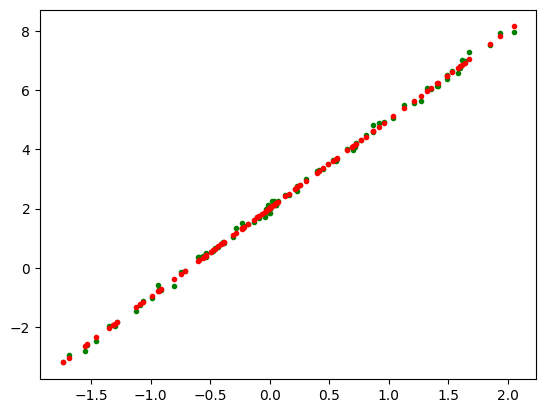

In [15]:
# Task: Linear Regression from scratch
x = torch.randn(100, 1)
y = 3 * x + 2 + torch.randn(100, 1) * 0.1

learning_rate = 0.01
epochs = 500

# Initialize W (weight) and b (bias) as tensors with random numbers from a normal distribution with requires_grad=True
W = torch.randn(1, 1, requires_grad=True)
b = torch.randn(1, requires_grad=True)

# Write the optimization loop with Forward, Loss, Backward, Gradient Descent, Zero-Grad
for epoch in range(epochs):

    hat_y = x @ W + b
    loss = ((hat_y - y) ** 2).mean()
    loss.backward()

    with torch.no_grad():
        W -= learning_rate * W.grad
        b -= learning_rate * b.grad

    W.grad.zero_()
    b.grad.zero_()        
    
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}: Loss = {loss}")

plt.plot(x.numpy(), y.numpy(), 'g.');
plt.plot(x.numpy(), hat_y.detach().numpy(), 'r.');
print(f'W = {W.item()}')
print(f'b = {b.item()}')

The training loss decreases smoothly and monotonically over the epochs, showing that the gradient descent procedure is stable and correctly implemented. The final learned parameters ($W ≈ 2.996$ and $b ≈ 2.019$) are very close to the true data-generating process 
$𝑦 = 3𝑥 + 2 + 𝜀$, with the remaining gap explained by the added Gaussian noise. The scatter plot confirms this result: the predicted values align almost perfectly with the observed data, indicating that the linear model has successfully captured the underlying linear relationship. This experiment validates the correct use of Autograd, the manual implementation of backpropagation, and the effectiveness of gradient descent in a simple regression setting.

---

## Designing Custom Data Pipelines

Standard datasets like MNIST comes with a ready-to-use PyTorch dataset class that provides access to the data: `torchvision.datasets.MNIST`.

However, this is not the case for most dataset, including the ones that we will probably create for your task.
Because of this, we must master the `Dataset` class of pytorch which is a central element.
The `Dataset` defines **what** the data is and how to get them.

* **Documentation:** [Custom Datasets Tutorial](https://pytorch.org/docs/stable/data.html)

In [19]:
class SineDataset(Dataset):
    """
    Subclassing Dataset requires implementing __len__ and __getitem__.
    This allows the DataLoader to index the data efficiently.
    """
    def __init__(self, num_samples=1000):
        # Create x uniformly from 0 to 4*pi
        self.x = torch.linspace(0, 4 * torch.pi, num_samples).unsqueeze(1)
        # Create y = sin(x) + Gaussian noise
        self.y = torch.sin(self.x) + 0.1 * torch.randn_like(self.x)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# Instantiate the SineDataset
dataset = SineDataset()
print(dataset[0])
print(len(dataset))

(tensor([0.]), tensor([0.1066]))
1000


The output shows that the first element of the dataset is a tuple $(x, y)$, where x is the input value and y is the corresponding target. Here, $x = 0.0$ corresponds to the first point in the interval $[0,4π]$, and $y ≈ 0$.1066 is equal to $sin(0)$ plus a small Gaussian noise, which explains why it is not exactly zero. The value `1000` confirms that the dataset contains $1000$ samples, as specified during initialization.

Another important class is the `DataLoader`. It defines **how** to query the Dataset to get a single batch (batch size, shuffling of the data at each epoch, multiprocessing).

In [22]:
# Task: Instantiate the DataLoader with a batch size of 32 and shuffling.

train_loader = DataLoader(
    dataset,
    batch_size=32,
    shuffle=True
)

x, y = next(iter(train_loader))
print(x.size(), y.size())

torch.Size([32, 1]) torch.Size([32, 1])


The output indicates that the DataLoader returns a mini-batch of 32 samples. Both the input tensor x and the target tensor y have shape (32, 1), meaning that each batch contains 32 scalar inputs and their corresponding scalar targets. This confirms that batching and dataset indexing are working correctly.

## Write a Neural Network

In PyTorch, there are two primary ways to define a neural network architecture. Choosing between them depends on whether we prioritize simplicity (`nn.Sequential`) or flexibility (`nn.Module`).

* `nn.Sequential`: This is the easiest and fastest way to build a model. we define a list of layers, and PyTorch automatically handles the data flow from one layer to the next in a linear "stack."
    * __Best for__: Simple, "feed-forward" architectures where each layer has exactly one input and one output.

* `nn.Module`: This is the professional standard for most research and production models. we create a Python class that inherits from nn.Module. we define your layers in the `__init__` method and the logic of the data flow in the `forward` method.
    * __Best for__: Complex architectures, models with branching logic, or when we need to inspect/manipulate data between layers.



### The nn.Sequential Abstraction

In PyTorch, `nn.Sequential` is a container module that allows us to stack layers in a fixed, linear order. It is the simplest way to build a neural network when your data flows directly from one layer to the next without any complex branching, skip-connections, or multiple inputs/outputs.

* **Documentation:** [nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)
* **Documentation:** [Non-linear Activations](https://www.google.com/search?q=https://pytorch.org/docs/stable/nn.html%23non-linear-activations-weighted-sum-non-linearity)

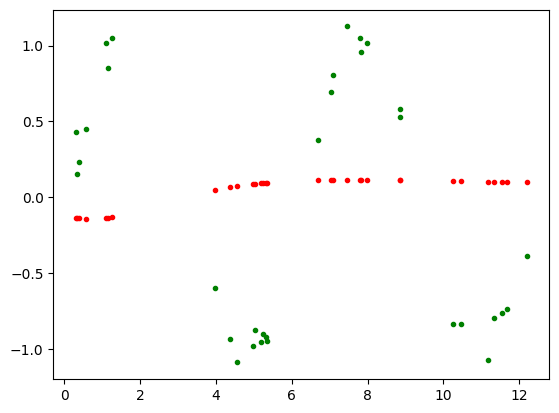

In [39]:
# Task: Define a simple MLP with two hidden layer (1 -> 64 -> 64 -> 1) with a Tanh activation function using nn.Sequential

model = nn.Sequential(
    nn.Linear(1, 64),
    nn.Tanh(),
    nn.Linear(64, 64),
    nn.Tanh(),
    nn.Linear(64, 1)
)

hat_y = model(x)
plt.plot(x.numpy(), y.numpy(), 'g.');
plt.plot(x.numpy(), hat_y.detach().numpy(), 'r.');

The plot shows that the neural network’s predictions (red points) are almost constant and do not follow the sinusoidal pattern of the data (green points). This indicates that the model has not been trained yet and is only producing outputs from its random initial weights. At this stage, the network has not learned the relationship between 𝑥 and 𝑦 ; training with a loss function and an optimizer is required for the predictions to start matching the sine-shaped structure of the data.

### The `nn.Module` Abstraction

Every neural network in PyTorch must inherit from `nn.Module`. This class tracks all parameters (weights/biases) defined within it. We usually define layers in `__init__` and the data flow in `forward`.

* **Documentation:** [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html)


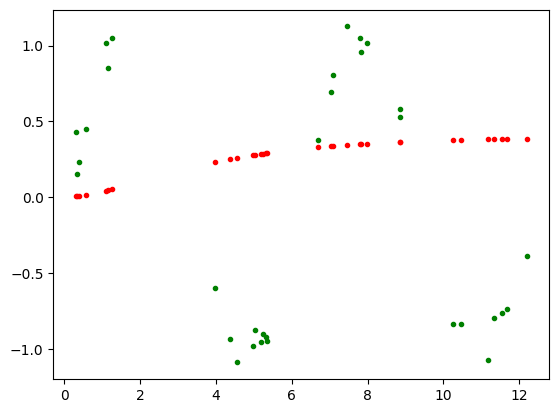

In [65]:
class RegressionMLP(nn.Module):
    def __init__(self, hidden_dim=64):
        super(RegressionMLP, self).__init__()

        self.fc1 = nn.Linear(1, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
        self.act = nn.Tanh()

    def forward(self, x):

        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        hat_y = self.fc3(x)

        return hat_y

model = RegressionMLP().to(device)
hat_y = model(x.to(device))
plt.plot(x.cpu().numpy(), y.cpu().numpy(), 'g.');
plt.plot(x.cpu().numpy(), hat_y.detach().cpu().numpy(), 'r.');

The plot shows that the predictions (red points) remain almost constant and do not follow the sinusoidal structure of the data (green points). This indicates that, as in the previous output, the neural network has not been trained yet. Switching from nn.Sequential to a custom nn.Module only changes how the model is defined, not its behavior: without an optimization loop (loss computation, backpropagation, and parameter updates), the model stays at its random initialization and produces nearly flat predictions. Training is therefore still required for the network to learn the underlying relationship.

---

## 5. The Optimization Loop

Training a model follows a strict 5-step choreography:
* Step 1: Clear previous gradients
* Step 2: Prediction (Forward pass)
* Step 3: Compute Loss
* Step 4: Backpropagation (Backward pass)
* Step 5: Update weights
        
Missing one step (especially `zero_grad()`) will lead to silent bugs where gradients accumulate across iterations.

We use the package `nn` to define the loss (MSE, BCE, ...).
* **Documentation:** [Loss Functions](https://www.google.com/search?q=https://pytorch.org/docs/stable/nn.html%23loss-functions)

We use the package `torch.optim` to handle weight updates (SGD, Momentum, Adam, ...).
* **Documentation:** [Optimizers](https://pytorch.org/docs/stable/optim.html)

In [66]:
# Task: Initialize MSE loss and the Adam optimizer (learning rate 0.005)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

history = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    for batch_x, batch_y in train_loader:
        # Step 0: Send data to GPU (or CPU if not available)
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        # Step 1: Clear previous gradients
        optimizer.zero_grad()

        # Step 2: Prediction (Forward pass)
        hat_y = model(batch_x)

        # Step 3: Compute Loss
        loss = criterion(hat_y, batch_y)

        # Step 4: Backpropagation (Backward pass)
        loss.backward()

        # Step 5: Update weights
        optimizer.step()

        epoch_loss += loss.item()

    history.append(epoch_loss / len(train_loader))
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}: Mean Squared Error = {history[-1]:.5f}")

Epoch 20: Mean Squared Error = 0.06789
Epoch 40: Mean Squared Error = 0.01831
Epoch 60: Mean Squared Error = 0.01763
Epoch 80: Mean Squared Error = 0.01395
Epoch 100: Mean Squared Error = 0.01239
Epoch 120: Mean Squared Error = 0.01759
Epoch 140: Mean Squared Error = 0.01403
Epoch 160: Mean Squared Error = 0.01264
Epoch 180: Mean Squared Error = 0.01503
Epoch 200: Mean Squared Error = 0.01277
Epoch 220: Mean Squared Error = 0.01373
Epoch 240: Mean Squared Error = 0.01542
Epoch 260: Mean Squared Error = 0.01197
Epoch 280: Mean Squared Error = 0.01304
Epoch 300: Mean Squared Error = 0.01347
Epoch 320: Mean Squared Error = 0.01288
Epoch 340: Mean Squared Error = 0.01231
Epoch 360: Mean Squared Error = 0.01310
Epoch 380: Mean Squared Error = 0.01550
Epoch 400: Mean Squared Error = 0.01243
Epoch 420: Mean Squared Error = 0.01379
Epoch 440: Mean Squared Error = 0.01720
Epoch 460: Mean Squared Error = 0.01188
Epoch 480: Mean Squared Error = 0.01308
Epoch 500: Mean Squared Error = 0.01501


---

## 6. Evaluating Performance

After training, we must visualize the **Loss Curve** to check for convergence and the **Model Fit** to see if our MLP actually learned the sine function.

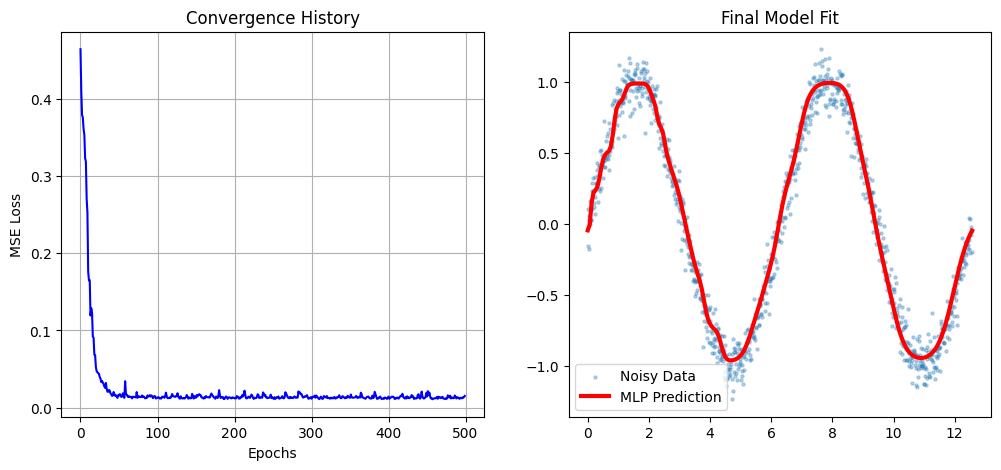

In [67]:
plt.figure(figsize=(12, 5))

# Plot 1: Learning Curve
plt.subplot(1, 2, 1)
plt.plot(history, color='blue', label='Train Loss')
plt.title("Convergence History")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.grid(True)

# Plot 2: Inference Comparison
plt.subplot(1, 2, 2)
model.eval() # Set model to evaluation mode (disables dropout/batchnorm if used)
with torch.no_grad(): # Disable gradient tracking for faster inference
    test_x = torch.linspace(0, 4 * np.pi, 200).view(-1, 1).to(device)
    test_y = model(test_x)

plt.scatter(dataset.x.cpu(), dataset.y.cpu(), s=5, alpha=0.3, label="Noisy Data")
plt.plot(test_x.cpu(), test_y.cpu(), color='red', lw=3, label="MLP Prediction")
plt.title("Final Model Fit")
plt.legend()
plt.show()

The learning curve shows a rapid decrease of the MSE during the first epochs, followed by a stable plateau at a low value, which indicates that the optimization has converged properly and the training process is stable. The final model fit confirms this behavior: the MLP prediction closely follows the underlying sinusoidal structure of the data while smoothing out the noise. This shows that the network has successfully learned the non-linear relationship $y=sin(x)$ from noisy observations without obvious underfitting or overfitting.

# Next steps:

* Try changing the `hidden_dim` from 64 to 4. Does the model still fit the curve?
* Swap `nn.Tanh()` for `nn.ReLU()` or `nn.Sigmoid()`. How does the loss curve change?
* Add a second `Dataset` for **Validation** and plot both training and validation loss.

1) Effect of Model Capacity (Hidden Dimension)

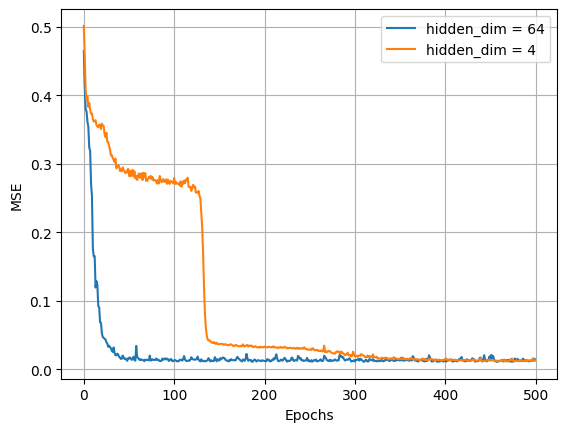

In [68]:
# Experiment 1: Reduce model capacity
small_model = RegressionMLP(hidden_dim=4).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(small_model.parameters(), lr=0.005)

small_history = []

for epoch in range(epochs):
    epoch_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()
        preds = small_model(batch_x)
        loss = criterion(preds, batch_y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    small_history.append(epoch_loss / len(train_loader))

plt.plot(history, label="hidden_dim = 64")
plt.plot(small_history, label="hidden_dim = 4")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.show()

The training loss shows that the model with `hidden_dim = 64` converges much faster and reaches a low error early, while the model with `hidden_dim = 4` decreases more slowly and remains at a higher loss for a long time. This indicates that the smaller model has limited capacity and struggles to represent the target function, leading to underfitting. Although both models eventually reach similar low losses after many epochs, the larger model is significantly more efficient and stable during training.

2) Effect of the Activation Function

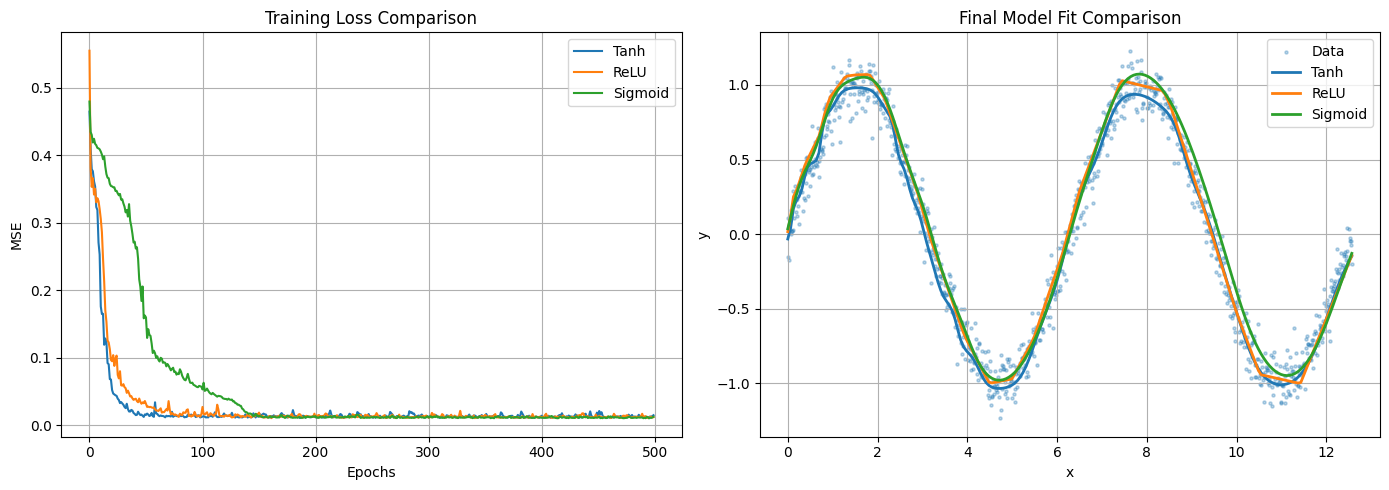

In [73]:
# Experiment 2: Compare activation functions (Tanh vs ReLU vs Sigmoid)

class RegressionMLPAct(nn.Module):
    def __init__(self, hidden_dim=64, act=nn.Tanh):
        super().__init__()
        self.fc1 = nn.Linear(1, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
        self.act = act()

    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        return self.fc3(x)


def train_model(model_, train_loader, criterion, lr=0.005, epochs=500, device="cpu"):
    model_ = model_.to(device)
    optimizer = optim.Adam(model_.parameters(), lr=lr)
    hist = []

    for epoch in range(epochs):
        model_.train()
        epoch_loss = 0.0

        for batch_x, batch_y in train_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            optimizer.zero_grad()
            hat_y = model_(batch_x)
            loss = criterion(hat_y, batch_y)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        hist.append(epoch_loss / len(train_loader))

    return model_, hist


# Train ReLU and Sigmoid (Tanh history already exists in `history` and model in `model`)
criterion = nn.MSELoss()

relu_model, relu_history = train_model(
    RegressionMLPAct(hidden_dim=64, act=nn.ReLU),
    train_loader, criterion, lr=0.005, epochs=epochs, device=device
)

sigmoid_model, sigmoid_history = train_model(
    RegressionMLPAct(hidden_dim=64, act=nn.Sigmoid),
    train_loader, criterion, lr=0.005, epochs=epochs, device=device
)

# Create side-by-side plots
plt.figure(figsize=(14, 5))

# Plot 1: Learning curves comparison
plt.subplot(1, 2, 1)
plt.plot(history, label="Tanh")
plt.plot(relu_history, label="ReLU")
plt.plot(sigmoid_history, label="Sigmoid")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("Training Loss Comparison")
plt.legend()
plt.grid(True)

# Plot 2: Model predictions comparison
plt.subplot(1, 2, 2)
model.eval()
relu_model.eval()
sigmoid_model.eval()

with torch.no_grad():
    y_tanh = model(test_x).cpu()
    y_relu = relu_model(test_x).cpu()
    y_sigmoid = sigmoid_model(test_x).cpu()

plt.scatter(dataset.x, dataset.y, s=5, alpha=0.3, label="Data")
plt.plot(test_x.cpu(), y_tanh, label="Tanh", linewidth=2)
plt.plot(test_x.cpu(), y_relu, label="ReLU", linewidth=2)
plt.plot(test_x.cpu(), y_sigmoid, label="Sigmoid", linewidth=2)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Final Model Fit Comparison")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

The training loss curves show that all three activation functions (Tanh, ReLU, and Sigmoid) eventually converge to a similar low MSE, indicating comparable final fitting capability. However, their convergence dynamics differ: Tanh converges the fastest and most smoothly, ReLU follows closely with slightly more variability, while Sigmoid converges significantly more slowly during the early epochs. The final model fit confirms these observations: all activations approximate the sine function well, but Tanh first and ReLU then, provide a cleaner and more accurate fit, whereas Sigmoid produces a slightly smoother but less precise approximation. This illustrates how the choice of activation mainly affects convergence speed and training dynamics rather than final performance in this setting.

3) Train / Validation Split and Generalization

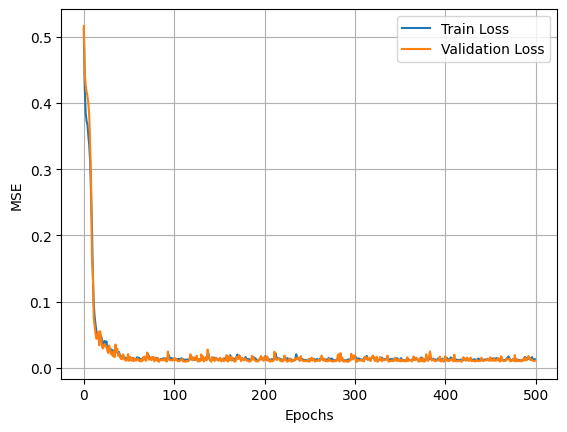

In [72]:
# Train / validation split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

model = RegressionMLP().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.005)
criterion = nn.MSELoss()

train_loss_hist, val_loss_hist = [], []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        loss = criterion(model(x_batch), y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            val_loss += criterion(model(x_batch), y_batch).item()

    train_loss_hist.append(train_loss / len(train_loader))
    val_loss_hist.append(val_loss / len(val_loader))

plt.plot(train_loss_hist, label="Train Loss")
plt.plot(val_loss_hist, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.show()

The training and validation loss curves decrease together and remain very close throughout training, indicating stable convergence and good generalization for the baseline model using the Tanh activation. There is no visible gap between the two curves, which suggests that the model does not overfit the training data and captures the underlying pattern rather than the noise.